In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from collections import defaultdict
import codecs

from sklearn.cluster import AgglomerativeClustering

import re
import pymorphy2
from string import punctuation
punctuation = punctuation + '—' + '•' + '§' + '№' + '»' + '›' + '«'
import nltk
from nltk.collocations import *
from nltk.corpus import stopwords

plt.style.use('ggplot')
%matplotlib inline

In [2]:
def clean(words):
    pymorphy = pymorphy2.MorphAnalyzer()
    words = ''.join(c for c in words if c not in punctuation)
    words = ' '.join(words.split())
    words = re.sub(r'\d+', '', words)
    words = [word for word in words.split() if word not in stopwords.words('russian')]
    
    result = []
    for w in words:
        w = pymorphy.parse(w)[0].normal_form
        result.append(w)
#     result = set(result)
    result = ' '.join(str(c) for c in result)
    return result

def clean_url(url):
    url = url.split('?')[0]
    url = url.split('%')[0]
    bad_words = ['ru', 'com', 'html', 'htm', 'php', 'net']
    url = re.sub(r'[\%\_./-]', ' ', url)
    url = re.sub('\d+', ' ', url)
    url = [elem.lower() for elem in url.split() 
         if elem not in bad_words
         and elem not in punctuation
         and len(elem) > 1]
    return ' '.join(url)

In [9]:
path = 'content/'
dat = '.dat'
information = dict()
# 027
for key in range(1, 28_027):
    print(key, flush=True)
    
    adress = ''
    texts = []
    len_h1 = 0
    len_h2 = 0
    len_h3 = 0
    len_b = 0
    len_i = 0
    len_a = 0
    len_img = 0
    len_table = 0
    len_tr = 0
    len_td = 0
    
    with codecs.open(path + str(key) + dat, 'r', 'utf-8') as f:
        
#         адрес
        adress = f.readline().strip('\n')
        
        soup = BeautifulSoup(f, 'lxml')
        
#         заголовок
        texts.append(soup.title.text)
    
#         description
        desc = soup.find('meta', attrs={'name': 'description'})
        if desc is not None:
            cont = desc.get('content')
            if cont is not None:
                texts.append(cont)
                
#         keywords
        keywords = soup.find('meta', attrs={'name': 'keywords'})
        if keywords is not None:
            cont = keywords.get('content')
            if cont is not None:
                texts.append(cont)
    
#         h1
        h1 = soup.findAll('h1')
        len_h1 = len(h1)
        if len(h1) != 0:
            for elem in h1:
                texts.append(elem.text)

#         h2
        h2 = soup.findAll('h2')
        len_h2 = len(h2)
        if len(h2) != 0:
            for elem in h2:
                texts.append(elem.text)
        
#         h3
        h3 = soup.findAll('h3')
        len_h3 = len(h3)
        if len(h3) != 0:
            for elem in h3:
                texts.append(elem.text)
        
#         b
        b = soup.findAll('b')
        len_b = len(b)
        if len(b) > 0:
            for elem in b:
                texts.append(elem.text)
        
#         i
        i = soup.findAll('i')
        len_i = len(i)
        if len(i) > 0:
            for elem in i:
                texts.append(elem.text)
        
#         a
        a = soup.findAll('a')
        len_a = len(a)
        
#         img
        img = soup.findAll('img')
        len_img = len(img)
        
#         table
        table = soup.findAll('table')
        len_table = len(table)
        
#         tr
        tr = soup.findAll('tr')
        len_tr = len(tr)
        
#         td
        td = soup.findAll('td')
        len_td = len(td)
                
    texts = ' '.join(texts)
    texts = clean(texts)
    
    information[key] = (adress, texts, len_h1, len_h2, len_h3, 
                      len_b, len_i, len_a, len_img, 
                      len_table, len_tr, len_td)

1


In [ ]:
(adress, texts, len_h1, len_h2, len_h3, len_b, len_i, len_a, len_img, len_table, len_tr, len_td)

In [12]:
for key in information:
    with codecs.open('content/cleaned/' + str(key) + '.txt', 'w', 'utf-8') as f:
        for elem in information[key]:
            print(elem, file=f)

_____

In [3]:
information = {}

for key in range(1, 28_027):
    tpl = []
    with codecs.open('content/cleaned/' + str(key) + '.txt', 'r', 'utf-8') as f:
        for elem in f:
            tpl.append(elem.strip())
    for i in range(2, len(tpl)):
        tpl[i] = int(tpl[i])
    information[key] = tuple(tpl)

In [4]:
titles = {}
with open('docs_titles.tsv', 'r', encoding='utf-8',) as f:
    for line in f:
        pair = line.strip().split('\t')
        if pair[0] == 'doc_id':
            continue
        if len(pair) == 2:
            titles[int(pair[0])] = pair[1]
        else:
            titles[int(pair[0])] = ''

In [5]:
pymorphy = pymorphy2.MorphAnalyzer()

for elem in titles:
    words = titles[elem]
    words = ''.join(c for c in words if c not in punctuation)
    words = ' '.join(words.split())
#     words = re.sub(r'\d+', '', words)
    words = [word for word in words.split() if word not in stopwords.words('russian')]
    
    result = []
    for w in words:
        w = pymorphy.parse(w)[0].normal_form
        result.append(w)
#     result = set(result)
    result = ' '.join(str(c) for c in result)
    titles[elem] = result

In [6]:
train_data = pd.read_csv('train_groups.csv')

traingroups_data = {}

for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    document = information[doc_id]
    all_params = (doc_id,) + document + (target,)
    if doc_group not in traingroups_data:
        traingroups_data[doc_group] = []
    traingroups_data[doc_group].append(all_params)

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.spatial.distance import pdist, cdist
from sklearn.decomposition import TruncatedSVD, PCA
from collections import Counter

y_train = []
X_train = np.array([])
groups_train = []
avg_devs = []
avg_devs_eng = []
avg_digits_lens = []
collocs = []
bigrams = []

html_attrs = np.array([])

pw_dists = np.array([])

agg_clust = np.array([])

diff_from_mean = np.array([])

urls_sorted = np.array([])

all_non_dist = np.array([])

pw_dists_urls = np.array([])


for new_group in traingroups_data:
    docs = traingroups_data[new_group]
    lens = []
    eng_lens = []
    digits_lens = []
    tmp_X_train = []
    corpus = []
    html_attrs_group = np.array([])
    
    urls = []
    
    tmp_all_non_dist = []
    
    for k, (doc_id, adress, texts, len_h1, len_h2, len_h3, len_b, len_i, len_a, len_img, len_table, len_tr, len_td, target_id) in enumerate(docs):
        
        corpus.append(texts)
        urls.append(clean_url(adress))
        y_train.append(target_id)
        groups_train.append(new_group)
        
        title = titles[doc_id]
        
        all_dist = []
        non_dist = []
        
        attrs = np.array((len_h1, len_h2, len_h3, 
                         len_b, len_i, len_a, len_img, 
                         len_table, len_tr, len_td))
        
#         sum_attrs = attrs.sum()
#         html_attrs_group.append(sum_attrs)
        
        if len(html_attrs_group) == 0:
            html_attrs_group = attrs
        else:
            html_attrs_group = np.vstack((html_attrs_group, attrs))
        
        words = re.sub(r'\d+', '', title)
        words = set(words.strip().split())
        
        len_words = len(words)
        lens.append(len_words)
        
#         eng_letters = re.findall(r'[a-zA-Z]', title)
        eng_letters = list(map(lambda t: re.findall(r'[a-zA-Z]', t), words))
#         eng_lens.append(len(eng_letters))
        eng_lens.append(len([elem for elem in eng_letters if len(elem) > 0]))
        
#         digits = re.findall(r'\d', title)
        digits = list(map(lambda w: re.findall(r'\d', w), set(title.strip().split())))
#         digits_lens.append(1 if len(digits) > 0 else 0)
        digits_lens.append(len([elem for elem in digits if len(elem) > 0]))
        
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j  = docs[j][0]
            title_j = titles[doc_id_j]
            words_j = set(title_j.strip().split())
            dist = len(words.intersection(words_j)) 
            uni = len(words.union(words_j))
#             all_dist.append(dist)
            non_dist.append(uni - dist)
            uni = uni if uni > 0 else 1
            all_dist.append(dist/uni)
        tmp_X_train.append(sorted(all_dist, reverse=True)[0:15])
        tmp_all_non_dist.append(sorted(non_dist, reverse=True)[0:10])
        
        
#     анализ длин, числа английских слов, числа чисел

    lens = np.array(lens)
    lens = (lens - lens.mean()) / lens.std()
    
    for elem in lens:
        avg_devs.append(elem)
        
        
    eng_lens = np.array(eng_lens)
#     eng_lens = (eng_lens - eng_lens.mean())
    
    for elem in eng_lens:
        avg_devs_eng.append(elem)
        
    
    digits_lens = np.array(digits_lens)
#     std = digits_lens.std()
#     std = std if std > 0 else 1
#     digits_lens = (digits_lens - digits_lens.mean()) 

    for elem in digits_lens:
        avg_digits_lens.append(elem)
        
        
#     работаем с отличиями/сходставми по titles

    tmp_X_train = np.array(tmp_X_train)
    
    if X_train.shape[0] == 0:
        X_train = tmp_X_train
    else:
        X_train = np.vstack((X_train, tmp_X_train))
        
        
    tmp_all_non_dist = np.array(tmp_all_non_dist)
    
    if all_non_dist.shape[0] == 0:
        all_non_dist = tmp_all_non_dist
    else:
        all_non_dist = np.vstack((all_non_dist, tmp_all_non_dist))
        
    
    
#     анализ тегов страниц html

#     html_attrs_group = np.array(html_attrs_group)
    mean_attrs = html_attrs_group.mean(axis=0)
    std_attrs = html_attrs_group.std(axis=0)
    html_attrs_group = ( html_attrs_group - mean_attrs ) / std_attrs
    
    if len(html_attrs) == 0:
        html_attrs = html_attrs_group
    else:
        html_attrs = np.vstack((html_attrs, html_attrs_group))
        
    

#     поиск коллокаций по всему объему текстов
    
    m = ' '.join(corpus).split()

    N_best = 100
    bm = nltk.collocations.BigramAssocMeasures()
    f = BigramCollocationFinder.from_words(m)
    f.apply_freq_filter(5)
#     raw_freq_ranking = [' '.join(i) for i in f.nbest(bm.raw_freq, N_best)]
    tscore_ranking = [' '.join(i) for i in f.nbest(bm.student_t, N_best)]
#     pmi_ranking = [' '.join(i) for i in f.nbest(bm.pmi, N_best)]
#     llr_ranking = [' '. join(i) for i in f.nbest(bm.likelihood_ratio, N_best)]
#     chi2_ranking = [' '.join(i) for i in f.nbest(bm.chi_sq, N_best)]

    ranking = tscore_ranking
    res = []
    for i in range(len(corpus)):
        sum_ = 0
        for rank in ranking[:4]:
            if rank.split()[0] in corpus[i] and rank.split()[1] in corpus[i]:
#             if rank in corpus[i]:
                sum_ += 1
        res.append(sum_)
            
    collocs = collocs + res
    
    
#     поиск чистых биграмм

    prog = re.compile('[А-Яа-я]+')
    m = ' '.join(corpus)
    bg = list(nltk.bigrams(prog.findall(m.lower())))
    bgfd = nltk.FreqDist(bg)
    bc = bgfd.most_common(5)
    bc = [' '.join(elem[0]) for elem in bc]
    
    res = []
    for i in range(len(corpus)):
        sum_ = 0
        for bigr in bc:
            if bigr in corpus[i]:
                sum_ += 1
        res.append(sum_)
        
    bigrams = bigrams + res
    
        
        
#     векторизация и понижение размерности
        
#     vectorizer = TfidfVectorizer()
    vectorizer = CountVectorizer()
    corpus = vectorizer.fit_transform(corpus)
        
    num_of_comp = 100
    
    trsvd = TruncatedSVD(n_components=num_of_comp, random_state=5678)
    trsvd.fit(corpus)
    
    svd_corpus = trsvd.transform(corpus)
    
    
    
#     кластеризация полученного массива данных
    
    agglom = AgglomerativeClustering(n_clusters=2)
    agglom.fit(svd_corpus)
    pred_agg = agglom.labels_
    
    agg_clust = np.hstack((agg_clust, pred_agg))
    
    
#     смотрим на попарные расстояния
    
    pdsts = cdist(svd_corpus, svd_corpus, 'cosine')
    pdsts[np.isnan(pdsts)] = 1
    std = pdsts.std(axis=1)
    std[std == 0] = 1
#     avg_pdsts = ( pdsts - pdsts.mean(axis=1) ) / std
    avg_pdsts =  pdsts.mean(axis=1)
#     avg_pdsts =  np.percentile(pdsts, 20, axis=1) 
    
#     dfm = np.linalg.norm(avg_pdsts, axis=1)
    dfm = avg_pdsts
    diff_from_mean = np.hstack((diff_from_mean, dfm))
    
    

    cols = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    s_pdsts = np.sort(pdsts, axis=1)[:,cols]
    
    s_pdsts[np.isnan(s_pdsts)] = 1
    
    if pw_dists.shape[0] == 0:
        pw_dists = s_pdsts
    else:
        pw_dists = np.vstack((pw_dists, s_pdsts))
        
    
#     анализ url'ов

    urls_analys = np.array([])
    for i in range(len(urls)):
        url_line = []
        for j in range(len(urls)):
            if i != j:
                elem_i = urls[i]
                elem_j = urls[j]
                uni = len(set(elem_i.split()).union(set(elem_j.split())))
                dist = len(set(elem_i.split()).intersection(set(elem_j.split())))
                url_line.append(dist/uni)
        url_line = np.array(url_line)
        if len(urls_analys) == 0:
            urls_analys = np.array(url_line)
        else:
            urls_analys = np.vstack((urls_analys, url_line))
            
    
    urls_analys = np.sort(urls_analys, axis=1)[:,[-1,-2,-3,-4,-5]]
    
    if urls_sorted.shape[0] == 0:
        urls_sorted = urls_analys
    else:
        urls_sorted = np.vstack((urls_sorted, urls_analys))
        
        
        
#     vectorizer = CountVectorizer()
#     urls = vectorizer.fit_transform(urls)
    
#     num_of_comp = 50
    
#     trsvd = TruncatedSVD(n_components=num_of_comp, random_state=5678)
#     trsvd.fit(urls)
    
#     svd_urls = trsvd.transform(urls)
    
#     pdsts = cdist(svd_urls, svd_urls, 'cosine')
    
#     cols = [11,12,13,14,15,16,17,18,19,20]
#     s_pdsts = np.sort(pdsts, axis=1)[:,cols]
    
#     s_pdsts[np.isnan(s_pdsts)] = 1
    
#     if pw_dists_urls.shape[0] == 0:
#         pw_dists_urls = s_pdsts
#     else:
#         pw_dists_urls = np.vstack((pw_dists_urls, s_pdsts))
    
    


        
X_train = np.array(X_train)
avg_devs = np.array(avg_devs)
avg_devs_eng = np.array(avg_devs_eng)
avg_digits_lens = np.array(avg_digits_lens)
collocs = np.array(collocs)
bigrams = np.array(bigrams)


X_train = np.hstack((X_train, all_non_dist))
X_train = np.hstack((X_train, html_attrs))
X_train = np.hstack((X_train, pw_dists))
X_train = np.hstack((X_train, avg_devs.reshape(-1, 1)))
X_train = np.hstack((X_train, avg_devs_eng.reshape(-1, 1)))
X_train = np.hstack((X_train, avg_digits_lens.reshape(-1, 1)))
X_train = np.hstack((X_train, collocs.reshape(-1, 1)))
X_train = np.hstack((X_train, bigrams.reshape(-1, 1)))
X_train = np.hstack((X_train, agg_clust.reshape(-1, 1)))
X_train = np.hstack((X_train, diff_from_mean.reshape(-1, 1)))
X_train = np.hstack((X_train, urls_sorted))
# X_train = np.hstack((X_train, pw_dists_urls))


y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 67) (11690,) (11690,)


In [95]:
# agglom = AgglomerativeClustering(n_clusters=2)
# agglom.fit(X_train)
# pred_agg = agglom.labels_

# X_train = np.hstack((X_train, pred_agg.reshape(-1,1)))

In [96]:
# corpus = []
# for elem in traingroups_data[16]:
#     corpus.append(elem[2])

# prog = re.compile('[А-Яа-я]+')
# m = ' '.join(corpus)
# bg = list(nltk.bigrams(prog.findall(corpus.lower())))
# bgfd = nltk.FreqDist(bg)
# bc = bgfd.most_common(5)
# bc = [' '.join(elem[0]) for elem in bc]
# bc

In [97]:
# N_best = 100
# bm = nltk.collocations.BigramAssocMeasures()
# f = BigramCollocationFinder.from_words(corpus.split())
# f.apply_freq_filter(5)
# #     raw_freq_ranking = [' '.join(i) for i in f.nbest(bm.raw_freq, N_best)]
# tscore_ranking = [' '.join(i) for i in f.nbest(bm.student_t, N_best)]
# #     pmi_ranking = [' '.join(i) for i in f.nbest(bm.pmi, N_best)]
# #     llr_ranking = [' '. join(i) for i in f.nbest(bm.likelihood_ratio, N_best)]
# #     chi2_ranking = [' '.join(i) for i in f.nbest(bm.chi_sq, N_best)]

# tscore_ranking[1].split()[0]

In [98]:
# def clean_url(url):
#     url = url.split('?')[0]
#     url = url.split('%')[0]
#     bad_words = ['ru', 'com', 'html', 'htm', 'php', 'net']
#     url = re.sub(r'[\%\_./-]', ' ', url)
#     url = re.sub('\d+', ' ', url)
#     url = [elem.lower() for elem in url.split() 
#          if elem not in bad_words
#          and elem not in punctuation
#          and len(elem) > 1]
#     return ' '.join(url)
# urlss = [clean_url(url) for url in urls]

# a = np.array([])
# for i in range(len(urlss)):
#     b = []
#     for j in range(len(urlss)):
#         if i != j:
#             elem_i = urlss[i]
#             elem_j = urlss[j]
#             num = len(set(elem_i.split()).intersection(set(elem_j.split())))
#             b.append(num)
#     b = np.array(b)
#     if len(a) == 0:
#         a = np.array(b)
#     else:
#         a = np.vstack((a, b))
# np.sort(a, axis=1)[:,[-1,-2,-3,-4,-5]]

In [99]:
# trsvd = TruncatedSVD(n_components=5)
# trsvd.fit(X_train)
# X_train = trsvd.transform(X_train)

In [100]:
s = pd.DataFrame(X_train)
s['target'] = y_train
s.corr()['target'].iloc[:33]

0     0.535230
1     0.588034
2     0.604610
3     0.619135
4     0.628542
5     0.629128
6     0.627278
7     0.625607
8     0.620982
9     0.620553
10    0.618298
11    0.616143
12    0.614633
13    0.613836
14    0.612768
15   -0.300837
16   -0.305885
17   -0.296503
18   -0.305786
19   -0.306038
20   -0.302952
21   -0.300119
22   -0.295646
23   -0.296599
24   -0.299130
25    0.006085
26   -0.000942
27   -0.017579
28   -0.036367
29   -0.008635
30   -0.016655
31   -0.026101
32   -0.044946
Name: target, dtype: float64

In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [101]:
st_sc = StandardScaler()
X_train = st_sc.fit_transform(X_train)

In [102]:
differ_groups = set(groups_train)
inds = np.arange(len(X_train))
flag = 0
np.random.seed(254)



for group in differ_groups:
    group_inds = inds[groups_train == group]
    np.random.shuffle(group_inds)
    bound = int(len(group_inds) * 0.2)
    
    if flag == 0:
        x_train_ = X_train[group_inds[0:bound]]
        x_val_ = X_train[group_inds[bound:]]
        y_train_ = y_train[group_inds[0:bound]]
        y_val_ = y_train[group_inds[bound:]]
        flag = 1
        
    x_train_ = np.concatenate((x_train_, X_train[group_inds[0:bound]]), axis=0)
    x_val_ = np.concatenate((x_val_, X_train[group_inds[bound:]]), axis=0)
    y_train_ = np.concatenate((y_train_, y_train[group_inds[0:bound]]), axis=0)
    y_val_ = np.concatenate((y_val_, y_train[group_inds[bound:]]), axis=0)

In [103]:
logreg = LogisticRegression(class_weight='balanced', random_state=4567)
logreg.fit(x_train_, y_train_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=4567, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [104]:
from sklearn.ensemble import GradientBoostingClassifier
from itertools import product

depths = [i+1 for i in range(10)]
# nums = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
nums = [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]

best_score = 0
best_param = (0, 0)

params = product(depths, nums)

for param in params:
    print(param)
    grd_clf = GradientBoostingClassifier(max_depth = param[0], n_estimators=param[1], random_state=3456)
    grd_clf.fit(x_train_, y_train_)
    y_pred_ = grd_clf.predict(x_val_)
    score = f1_score(y_pred_, y_val_)
    print(score)
    
    if score > best_score:
        best_score = score
        best_param = param

print(best_score)
print(best_param)

(1, 50)
0.7175337186897881
(1, 60)
0.7156919513607412
(1, 70)
0.7205542725173208
(1, 80)
0.7203700134900752
(1, 90)
0.7196459495862998
(1, 100)
0.722211556920714
(1, 110)
0.7198002688688305
(1, 120)
0.7195075028857254
(1, 130)
0.7209838585703305
(1, 140)
0.7200307869924957
(1, 150)
0.72
(2, 50)
0.7233294255568582
(2, 60)
0.724124513618677
(2, 70)
0.7264224473889321
(2, 80)
0.7303873856336383
(2, 90)
0.731526613374927
(2, 100)
0.7332814930015552
(2, 110)
0.7326848249027238
(2, 120)
0.7366990291262135
(2, 130)
0.7373933281613653
(2, 140)
0.7355611357929304
(2, 150)
0.7365373480023161
(3, 50)
0.7264677574590952
(3, 60)
0.7315577696876796
(3, 70)
0.7336779628565959
(3, 80)
0.7372248803827751
(3, 90)
0.7382909577518639
(3, 100)
0.7383088375644207
(3, 110)
0.7401755055322395
(3, 120)
0.7395118230358506
(3, 130)
0.7386493704692865
(3, 140)
0.7380679648720887
(3, 150)
0.7398095238095238
(4, 50)
0.7273426977102174
(4, 60)
0.7303912121796108
(4, 70)
0.7329742208541746
(4, 80)
0.7349051178838414


In [105]:
from itertools import product
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

depths = [i+1 for i in range(1)]
nums = [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
rates = [0.1*(i + 1) for i in range(10)]

best_score = 0
best_param = (0, 0, 0)

params = product(depths, nums, rates)

for param in params:
    print(param)
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(class_weight = 'balanced', max_depth = param[0], random_state=2345), 
                             n_estimators=param[1], 
                             algorithm='SAMME.R', 
                             learning_rate=param[2],
                             random_state = 7890)
    
    ada_clf.fit(x_train_, y_train_)
    y_pred_ = ada_clf.predict(x_val_)
    score = f1_score(y_pred_, y_val_)
    print(score)
    
    if score > best_score:
        best_score = score
        best_param = param

print(best_score)
print(best_param)

(1, 50, 0.1)
0.7221864951768489
(1, 50, 0.2)
0.724315619967794
(1, 50, 0.30000000000000004)
0.7246564268391269
(1, 50, 0.4)
0.7225848563968669
(1, 50, 0.5)
0.7211871393239899
(1, 50, 0.6000000000000001)
0.7202106649111258
(1, 50, 0.7000000000000001)
0.7215480485405051
(1, 50, 0.8)
0.7218837477358802
(1, 50, 0.9)
0.7186932849364791
(1, 50, 1.0)
0.7173191771731918
(1, 60, 0.1)
0.7239046391752577
(1, 60, 0.2)
0.724154667529526
(1, 60, 0.30000000000000004)
0.7274785702733301
(1, 60, 0.4)
0.7217105263157895
(1, 60, 0.5)
0.7237715803452854
(1, 60, 0.6000000000000001)
0.7198417930125247
(1, 60, 0.7000000000000001)
0.721829248231617
(1, 60, 0.8)
0.7204886907710087
(1, 60, 0.9)
0.7209572876848928
(1, 60, 1.0)
0.7175264661401446
(1, 70, 0.1)
0.7264211886304909
(1, 70, 0.2)
0.7248865845755021
(1, 70, 0.30000000000000004)
0.7265054374289889
(1, 70, 0.4)
0.7220121650501397
(1, 70, 0.5)
0.7225270157938487
(1, 70, 0.6000000000000001)
0.7226723995369605
(1, 70, 0.7000000000000001)
0.72724246962889
(1,

In [106]:
grd_clf = GradientBoostingClassifier(max_depth = 9, n_estimators=150, random_state=3456)
grd_clf.fit(x_train_, y_train_)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=9,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='auto',
                           random_state=3456, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [107]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(class_weight = 'balanced', max_depth = 1, random_state=2345), 
                             n_estimators=120, 
                             algorithm='SAMME.R', 
                             learning_rate=0.3,
                             random_state = 7890)
ada_clf.fit(x_train_, y_train_)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=2345,
                       

In [108]:
y_pred_3 = logreg.predict_proba(x_val_)

In [109]:
y_pred_1 = grd_clf.predict_proba(x_val_)

In [110]:
y_pred_2 = ada_clf.predict_proba(x_val_)

In [122]:
y_pred_ = grd_clf.predict(x_val_)

In [119]:
y_pred_ = np.argmax((y_pred_1 + y_pred_2 + y_pred_3)/3, axis=1)

In [124]:
y_pred_ = np.argmax((y_pred_1 + y_pred_3)/2, axis=1)

In [125]:
from sklearn.metrics import f1_score, precision_score, recall_score, auc, roc_curve
print(f'F1 is {f1_score(y_pred_, y_val_)}')
print(f'Precision is {precision_score(y_pred_, y_val_)}')
print(f'Recall is {recall_score(y_pred_, y_val_)}')

F1 is 0.7520507084265474
Precision is 0.7484230055658627
Recall is 0.7557137504683402


In [115]:
Counter(y_pred_), Counter(y_val_)

(Counter({0: 6817, 1: 2669}), Counter({0: 6791, 1: 2695}))

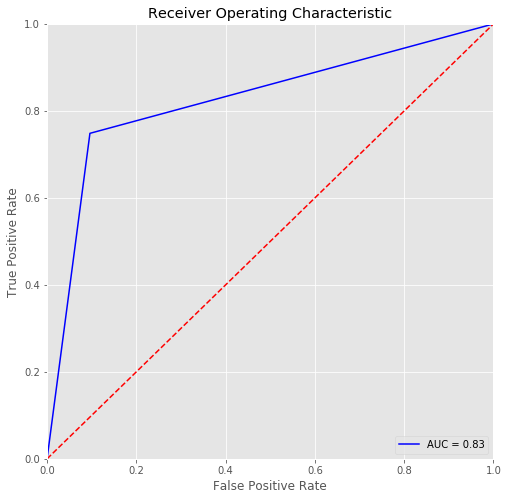

In [126]:
fpr, tpr, thr = roc_curve(y_val_, y_pred_)
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Сделаем предсказание:

In [69]:
test_data = pd.read_csv('test_groups.csv')

testgroups_data = {}

for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    pair_id = new_doc['pair_id']
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    document = information[doc_id]
    all_params = (pair_id,) + (doc_id,) + document
    if doc_group not in testgroups_data:
        testgroups_data[doc_group] = []
    testgroups_data[doc_group].append(all_params)

In [127]:
# here
X_test = np.array([])
groups_test = []
pair_id_test = []
avg_devs = []
avg_devs_eng = []
avg_digits_lens = []
collocs = []
bigrams = []


html_attrs = np.array([])

pw_dists = np.array([])

agg_clust = np.array([])

diff_from_mean = np.array([])

urls_sorted = np.array([])

all_non_dist = np.array([])

pw_dists_urls = np.array([])


for new_group in testgroups_data:
    docs = testgroups_data[new_group]
    lens = []
    eng_lens = []
    digits_lens = []
    tmp_X_test = []
    corpus = []
    html_attrs_group = np.array([])
    
    urls = []
    
    tmp_all_non_dist = []
    
    for k, (pair_id, doc_id, adress, texts, len_h1, len_h2, len_h3, len_b, len_i, len_a, len_img, len_table, len_tr, len_td) in enumerate(docs):
        
        corpus.append(texts)
        urls.append(clean_url(adress))
        pair_id_test.append(pair_id)
        groups_test.append(new_group)
        
        title = titles[doc_id]
        
        all_dist = []
        non_dist = []
        
        attrs = np.array((len_h1, len_h2, len_h3, 
                         len_b, len_i, len_a, len_img, 
                         len_table, len_tr, len_td))
        
#         sum_attrs = attrs.sum()
#         html_attrs_group.append(sum_attrs)
        
        if len(html_attrs_group) == 0:
            html_attrs_group = attrs
        else:
            html_attrs_group = np.vstack((html_attrs_group, attrs))
        
        words = re.sub(r'\d+', '', title)
        words = set(words.strip().split())
        
        len_words = len(words)
        lens.append(len_words)
        
#         eng_letters = re.findall(r'[a-zA-Z]', title)
        eng_letters = list(map(lambda t: re.findall(r'[a-zA-Z]', t), words))
#         eng_lens.append(len(eng_letters))
        eng_lens.append(len([elem for elem in eng_letters if len(elem) > 0]))
        
#         digits = re.findall(r'\d', title)
        digits = list(map(lambda w: re.findall(r'\d', w), set(title.strip().split())))
#         digits_lens.append(1 if len(digits) > 0 else 0)
        digits_lens.append(len([elem for elem in digits if len(elem) > 0]))
        
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j  = docs[j][1]
            title_j = titles[doc_id_j]
            words_j = set(title_j.strip().split())
            dist = len(words.intersection(words_j)) 
            uni = len(words.union(words_j))
#             all_dist.append(dist)
            non_dist.append(uni - dist)
            uni = uni if uni > 0 else 1
            all_dist.append(dist/uni)
        tmp_X_test.append(sorted(all_dist, reverse=True)[0:15])
        tmp_all_non_dist.append(sorted(non_dist, reverse=True)[0:10])
        
        
#     анализ длин, числа английских слов, числа чисел

    lens = np.array(lens)
    lens = (lens - lens.mean()) / lens.std()
    
    for elem in lens:
        avg_devs.append(elem)
        
        
    eng_lens = np.array(eng_lens)
#     eng_lens = (eng_lens - eng_lens.mean())
    
    for elem in eng_lens:
        avg_devs_eng.append(elem)
        
    
    digits_lens = np.array(digits_lens)
#     std = digits_lens.std()
#     std = std if std > 0 else 1
#     digits_lens = (digits_lens - digits_lens.mean()) 

    for elem in digits_lens:
        avg_digits_lens.append(elem)
        
        
#     работаем с отличиями/сходставми по titles

    tmp_X_test = np.array(tmp_X_test)
    
    if X_test.shape[0] == 0:
        X_test = tmp_X_test
    else:
        X_test = np.vstack((X_test, tmp_X_test))
        
        
    tmp_all_non_dist = np.array(tmp_all_non_dist)
    
    if all_non_dist.shape[0] == 0:
        all_non_dist = tmp_all_non_dist
    else:
        all_non_dist = np.vstack((all_non_dist, tmp_all_non_dist))
        
    
    
#     анализ тегов страниц html

#     html_attrs_group = np.array(html_attrs_group)
    mean_attrs = html_attrs_group.mean(axis=0)
    std_attrs = html_attrs_group.std(axis=0)
    html_attrs_group = ( html_attrs_group - mean_attrs ) / std_attrs
    
    if len(html_attrs) == 0:
        html_attrs = html_attrs_group
    else:
        html_attrs = np.vstack((html_attrs, html_attrs_group))
        
    

#     поиск коллокаций по всему объему текстов
    
    m = ' '.join(corpus).split()

    N_best = 100
    bm = nltk.collocations.BigramAssocMeasures()
    f = BigramCollocationFinder.from_words(m)
    f.apply_freq_filter(5)
#     raw_freq_ranking = [' '.join(i) for i in f.nbest(bm.raw_freq, N_best)]
    tscore_ranking = [' '.join(i) for i in f.nbest(bm.student_t, N_best)]
#     pmi_ranking = [' '.join(i) for i in f.nbest(bm.pmi, N_best)]
#     llr_ranking = [' '. join(i) for i in f.nbest(bm.likelihood_ratio, N_best)]
#     chi2_ranking = [' '.join(i) for i in f.nbest(bm.chi_sq, N_best)]

    ranking = tscore_ranking
    res = []
    for i in range(len(corpus)):
        sum_ = 0
        for rank in ranking[:4]:
            if rank.split()[0] in corpus[i] and rank.split()[1] in corpus[i]:
#             if rank in corpus[i]:
                sum_ += 1
        res.append(sum_)
            
    collocs = collocs + res
    
    
#     поиск чистых биграмм

    prog = re.compile('[А-Яа-я]+')
    m = ' '.join(corpus)
    bg = list(nltk.bigrams(prog.findall(m.lower())))
    bgfd = nltk.FreqDist(bg)
    bc = bgfd.most_common(5)
    bc = [' '.join(elem[0]) for elem in bc]
    
    res = []
    for i in range(len(corpus)):
        sum_ = 0
        for bigr in bc:
            if bigr in corpus[i]:
                sum_ += 1
        res.append(sum_)
        
    bigrams = bigrams + res
    
        
        
#     векторизация и понижение размерности
        
#     vectorizer = TfidfVectorizer()
    vectorizer = CountVectorizer()
    corpus = vectorizer.fit_transform(corpus)
        
    num_of_comp = 100
    
    trsvd = TruncatedSVD(n_components=num_of_comp, random_state=5678)
    trsvd.fit(corpus)
    
    svd_corpus = trsvd.transform(corpus)
    
    
    
#     кластеризация полученного массива данных
    
    agglom = AgglomerativeClustering(n_clusters=2)
    agglom.fit(svd_corpus)
    pred_agg = agglom.labels_
    
    agg_clust = np.hstack((agg_clust, pred_agg))
    
    
#     смотрим на попарные расстояния
    
    pdsts = cdist(svd_corpus, svd_corpus, 'cosine')
    pdsts[np.isnan(pdsts)] = 1
    std = pdsts.std(axis=1)
    std[std == 0] = 1
#     avg_pdsts = ( pdsts - pdsts.mean(axis=1) ) / std
    avg_pdsts =  pdsts.mean(axis=1)
#     avg_pdsts =  np.percentile(pdsts, 20, axis=1) 
    
#     dfm = np.linalg.norm(avg_pdsts, axis=1)
    dfm = avg_pdsts
    diff_from_mean = np.hstack((diff_from_mean, dfm))
    
    

    cols = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    s_pdsts = np.sort(pdsts, axis=1)[:,cols]
    
    s_pdsts[np.isnan(s_pdsts)] = 1
    
    if pw_dists.shape[0] == 0:
        pw_dists = s_pdsts
    else:
        pw_dists = np.vstack((pw_dists, s_pdsts))
        
    
#     анализ url'ов

    urls_analys = np.array([])
    for i in range(len(urls)):
        url_line = []
        for j in range(len(urls)):
            if i != j:
                elem_i = urls[i]
                elem_j = urls[j]
                uni = len(set(elem_i.split()).union(set(elem_j.split())))
                dist = len(set(elem_i.split()).intersection(set(elem_j.split())))
                url_line.append(dist/uni)
        url_line = np.array(url_line)
        if len(urls_analys) == 0:
            urls_analys = np.array(url_line)
        else:
            urls_analys = np.vstack((urls_analys, url_line))
            
    
    urls_analys = np.sort(urls_analys, axis=1)[:,[-1,-2,-3,-4,-5]]
    
    if urls_sorted.shape[0] == 0:
        urls_sorted = urls_analys
    else:
        urls_sorted = np.vstack((urls_sorted, urls_analys))
        
        
        
#     vectorizer = CountVectorizer()
#     urls = vectorizer.fit_transform(urls)
    
#     num_of_comp = 50
    
#     trsvd = TruncatedSVD(n_components=num_of_comp, random_state=5678)
#     trsvd.fit(urls)
    
#     svd_urls = trsvd.transform(urls)
    
#     pdsts = cdist(svd_urls, svd_urls, 'cosine')
    
#     cols = [11,12,13,14,15,16,17,18,19,20]
#     s_pdsts = np.sort(pdsts, axis=1)[:,cols]
    
#     s_pdsts[np.isnan(s_pdsts)] = 1
    
#     if pw_dists_urls.shape[0] == 0:
#         pw_dists_urls = s_pdsts
#     else:
#         pw_dists_urls = np.vstack((pw_dists_urls, s_pdsts))
    
    

    


X_test = np.array(X_test)
avg_devs = np.array(avg_devs)
avg_devs_eng = np.array(avg_devs_eng)
avg_digits_lens = np.array(avg_digits_lens)
collocs = np.array(collocs)
bigrams = np.array(bigrams)

X_test = np.hstack((X_test, all_non_dist))
X_test = np.hstack((X_test, html_attrs))
X_test = np.hstack((X_test, pw_dists))
X_test = np.hstack((X_test, avg_devs.reshape(-1, 1)))
X_test = np.hstack((X_test, avg_devs_eng.reshape(-1, 1)))
X_test = np.hstack((X_test, avg_digits_lens.reshape(-1, 1)))
X_test = np.hstack((X_test, collocs.reshape(-1, 1)))
X_test = np.hstack((X_test, bigrams.reshape(-1, 1)))
X_test = np.hstack((X_test, agg_clust.reshape(-1, 1)))
X_test = np.hstack((X_test, diff_from_mean.reshape(-1, 1)))
X_test = np.hstack((X_test, urls_sorted))
# X_test = np.hstack((X_test, pw_dists_urls))

groups_test = np.array(groups_test)
pair_id_test = np.array(pair_id_test)
print (X_test.shape, groups_test.shape, pair_id_test.shape)

(16627, 67) (16627,) (16627,)


In [128]:
# agglom = AgglomerativeClustering(n_clusters=2)
# agglom.fit(X_test)
# pred_agg = agglom.labels_

# X_test = np.hstack((X_test, pred_agg.reshape(-1,1)))

In [129]:
X_test = st_sc.transform(X_test)

In [130]:
y_pred_test_3 = logreg.predict_proba(X_test)

In [131]:
y_pred_test_1 = grd_clf.predict_proba(X_test)

In [132]:
# y_pred_test_2 = ada_clf.predict_proba(X_test)

In [133]:
# y_pred_test = ada_clf.predict(X_test)

In [134]:
# y_pred_test = np.argmax((y_pred_test_1 + y_pred_test_2 + y_pred_test_3)/3, axis=1)

In [135]:
y_pred_test = np.argmax((y_pred_test_1 + y_pred_test_3)/2, axis=1)

In [136]:
file = open('submissions.csv', 'w')
file.write('pair_id,target\n')
for i in range(len(y_pred_test)):
    file.write(str(pair_id_test[i]) + ',' + str(int(y_pred_test[i])) + '\n')
file.close()